In [1]:
from __future__ import division, print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from corner import corner
from acor import acor
from matplotlib.colors import LogNorm

%matplotlib inline

In [63]:
plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,
        'ytick.major.size':6,
        'ytick.minor.size':3,
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        #'font.family': 'serif',
        #'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
         }

plt.rcParams.update(params)

In [2]:
ephem = 'DE421'
#ephem = 'bayesephem'

slice_yr = 9.0

rundir = '/home/pbaker/nanograv/bwm/slices/{:.1f}/{}/'.format(slice_yr, ephem)

In [3]:
# this changes depending on which "names" are used in enterprise....

with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# find BWM parameters
bwm_pars = []
for p in params:
    if 'bwm' in p:
        bwm_pars.append(p)

bwm_idx = [params.index(p) for p in bwm_pars]
idx_A = bwm_pars.index('log10_A_bwm')
idx_t0 = bwm_pars.index('t0_bwm')

In [4]:
chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                        sep='\t', dtype=float, header=None).values
burn = int(0.25 * len(chain_raw))
chain = chain_raw[burn:]    

chain_bwm = chain[:, bwm_idx]

corr = acor(chain[:,-4])[0]
N = len(chain_bwm)
print("{:.1f} yr -- {:s}".format(slice_yr, ephem))
#print("N = {}".format(N))
print("N = {}, corr = {}, Neff = {}".format(N, corr, N/corr))

9.0 yr -- DE421
N = 120825, corr = 130.2369612890813, Neff = 927.7320263316802


Text(0.5, 0, 'log_likelihood')

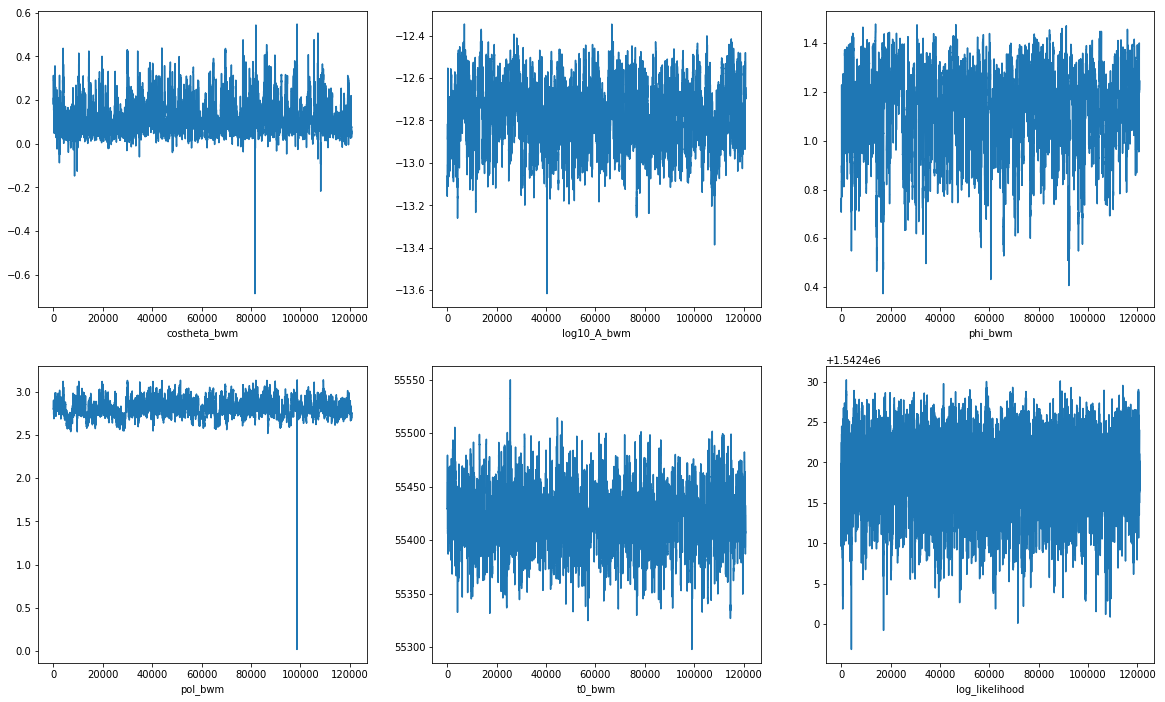

In [5]:
ax = []
fig = plt.figure(figsize=(20,12))

for pp, par in enumerate(bwm_pars):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].plot(chain_bwm[:,pp]) #, label='')
    ax[pp].set_xlabel(par)

ax.append(fig.add_subplot(2,3,6))
ax[5].plot(chain_raw[burn:,-4])
ax[5].set_xlabel('log_likelihood')

In [6]:
# wrap pol chain
chain_bwm[chain_bwm[:,3]>np.pi/2,3] -= np.pi

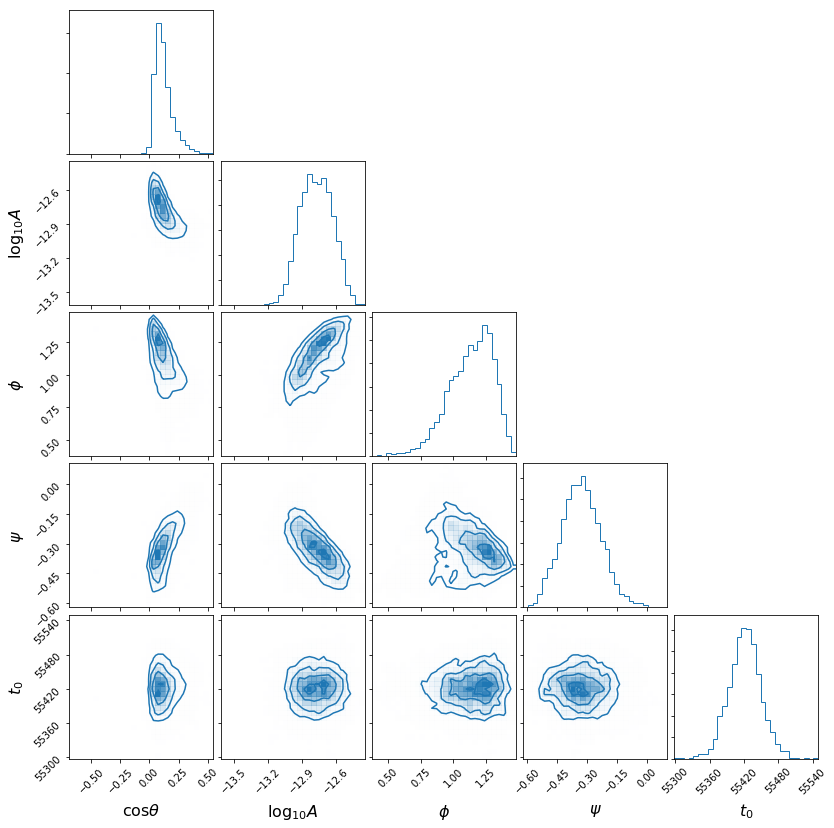

In [7]:
corner_kwargs = {'bins':30,
                 #'show_titles':True,
                 'labels':[r'$\cos\theta$', r'$\log_{10} A$', r'$\phi$', r'$\psi$', r'$t_0$'],
                 'label_kwargs':{'fontsize':16},
                 'smooth':0.5,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm, color='C0', **corner_kwargs);
#fig.suptitle('{:.1f} yr slice'.format(slice_yr));
fig.savefig('/home/pbaker/anomaly_corner.pdf')

In [8]:
fit = []
print('best fit, 90% CI')
for par, row in zip(bwm_pars, chain_bwm.T):
    x = np.percentile(row, [50, 5, 95])
    print("{0:s} = {1:.2f} [{2:.2f}, {3:.2f}]".format(par, *x))
    fit.append(x)

best fit, 90% CI
costheta_bwm = 0.10 [0.03, 0.28]
log10_A_bwm = -12.77 [-13.00, -12.54]
phi_bwm = 1.15 [0.82, 1.37]
pol_bwm = -0.33 [-0.49, -0.16]
t0_bwm = 55421.59 [55375.30, 55467.40]


In [13]:
from astropy.time import Time

In [11]:
print([55421.59-55375.30, 55467.40-55421.59])

[46.2899999999936, 45.81000000000495]


In [14]:
Time(55421.59, format='mjd').decimalyear

2010.6153150684931

In [18]:
np.divmod(1.15/(2*np.pi) * 24, 1) * np.array([1, 60])

array([ 4.        , 23.56058576])

In [23]:
np.divmod((np.pi/2 - np.arccos(0.10)) *180/np.pi, 1) * np.array([1, 60])

array([ 5.        , 44.35022864])

In [7]:
fit = []
print('best fit, 66% CI')
for par, row in zip(bwm_pars, chain_bwm.T):
    x = np.percentile(row, [50, 18, 84])
    print("{0:s} = {1:.2f} [{2:.2f}, {3:.2f}]".format(par, *x))
    fit.append(x)

best fit, 66% CI
costheta_bwm = 0.10 [0.05, 0.19]
log10_A_bwm = -12.77 [-12.91, -12.63]
phi_bwm = 1.15 [0.97, 1.30]
pol_bwm = -0.33 [-0.42, -0.23]
t0_bwm = 55421.59 [55396.49, 55447.48]


In [17]:
np.mean([fit[-1][0]-fit[-1][1], fit[-1][2]-fit[-1][0]])

25.494436791912449

In [12]:
print(np.array([fit[2][0]-fit[2][1], fit[2][2]-fit[2][0]]))

[ 0.17949489  0.14806388]


In [9]:
truths = np.array([x[0] for x in fit])
np.savetxt('bestfit_anomaly_params.dat', truths)

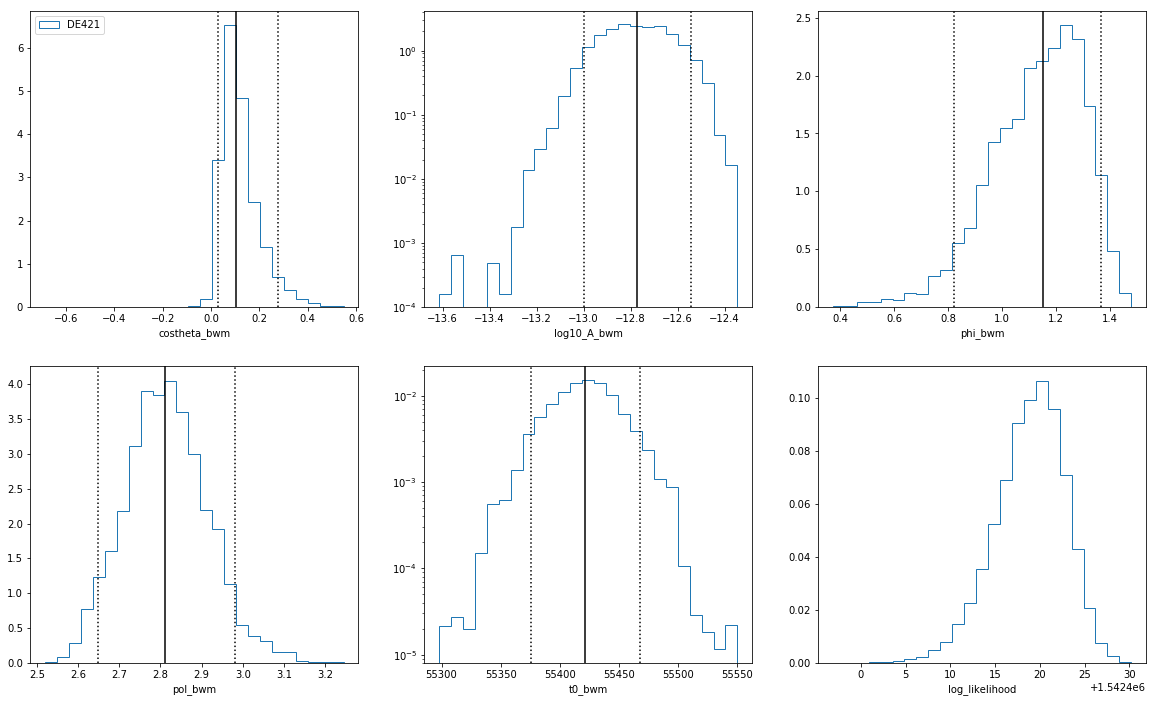

In [10]:
ax = []
fig = plt.figure(figsize=(20,12))

for pp, par in enumerate(bwm_pars):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].hist(chain_bwm[:,pp], bins=25, normed=True, histtype='step', label=ephem)
    ax[pp].set_xlabel(par)
    ax[pp].axvline(x=fit[pp][0], color='k')
    ax[pp].axvline(x=fit[pp][1], color='k', linestyle=':')
    ax[pp].axvline(x=fit[pp][2], color='k', linestyle=':')

ax[0].legend(loc='upper left')
ax[idx_A].set_yscale('log')
ax[idx_t0].set_yscale('log')

ax.append(fig.add_subplot(2,3,6))
ax[5].hist(chain[:,-4], bins=25, normed=True, histtype='step')
ax[5].set_xlabel('log_likelihood')

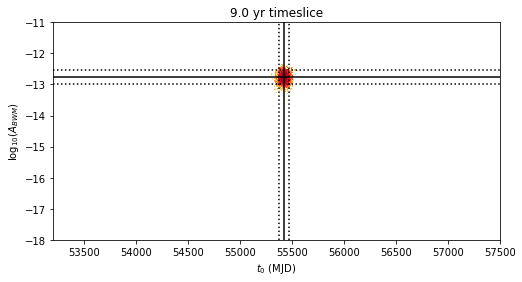

In [11]:
lognorm = LogNorm()

hist_kwargs = {'bins':40,
               'normed':True,
               'cmap':'YlOrRd',
               #'vmin':1.0e5,
               #'vmax':1.0e10,
               'norm':lognorm,
                }

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

t0_ch = chain_bwm[:,idx_t0]
h_ch = chain_bwm[:,idx_A]
    
ax.hist2d(t0_ch, h_ch, **hist_kwargs)

ax.axvline(x=fit[idx_t0][0], color='k')
ax.axvline(x=fit[idx_t0][1], color='k', linestyle=':')
ax.axvline(x=fit[idx_t0][2], color='k', linestyle=':')
ax.axhline(y=fit[idx_A][0], color='k')
ax.axhline(y=fit[idx_A][1], color='k', linestyle=':')
ax.axhline(y=fit[idx_A][2], color='k', linestyle=':')


ax.set_xlabel(r'$t_0$ (MJD)')
ax.set_ylabel(r'$\log_{10}(A_{BWM})$')
ax.set_ylim([-18,-11])
ax.set_xlim([53200, 57500])
ax.set_title('{:.1f} yr timeslice'.format(slice_yr))

## time sliced 1D hists

5.0 yr -- DE421
N = 369939, corr = 3.3, Neff = 111383.4
9.0 yr -- DE421
N = 120825, corr = 318.6, Neff = 379.3
11.5 yr -- DE421
N = 84075, corr = 173.7, Neff = 484.1


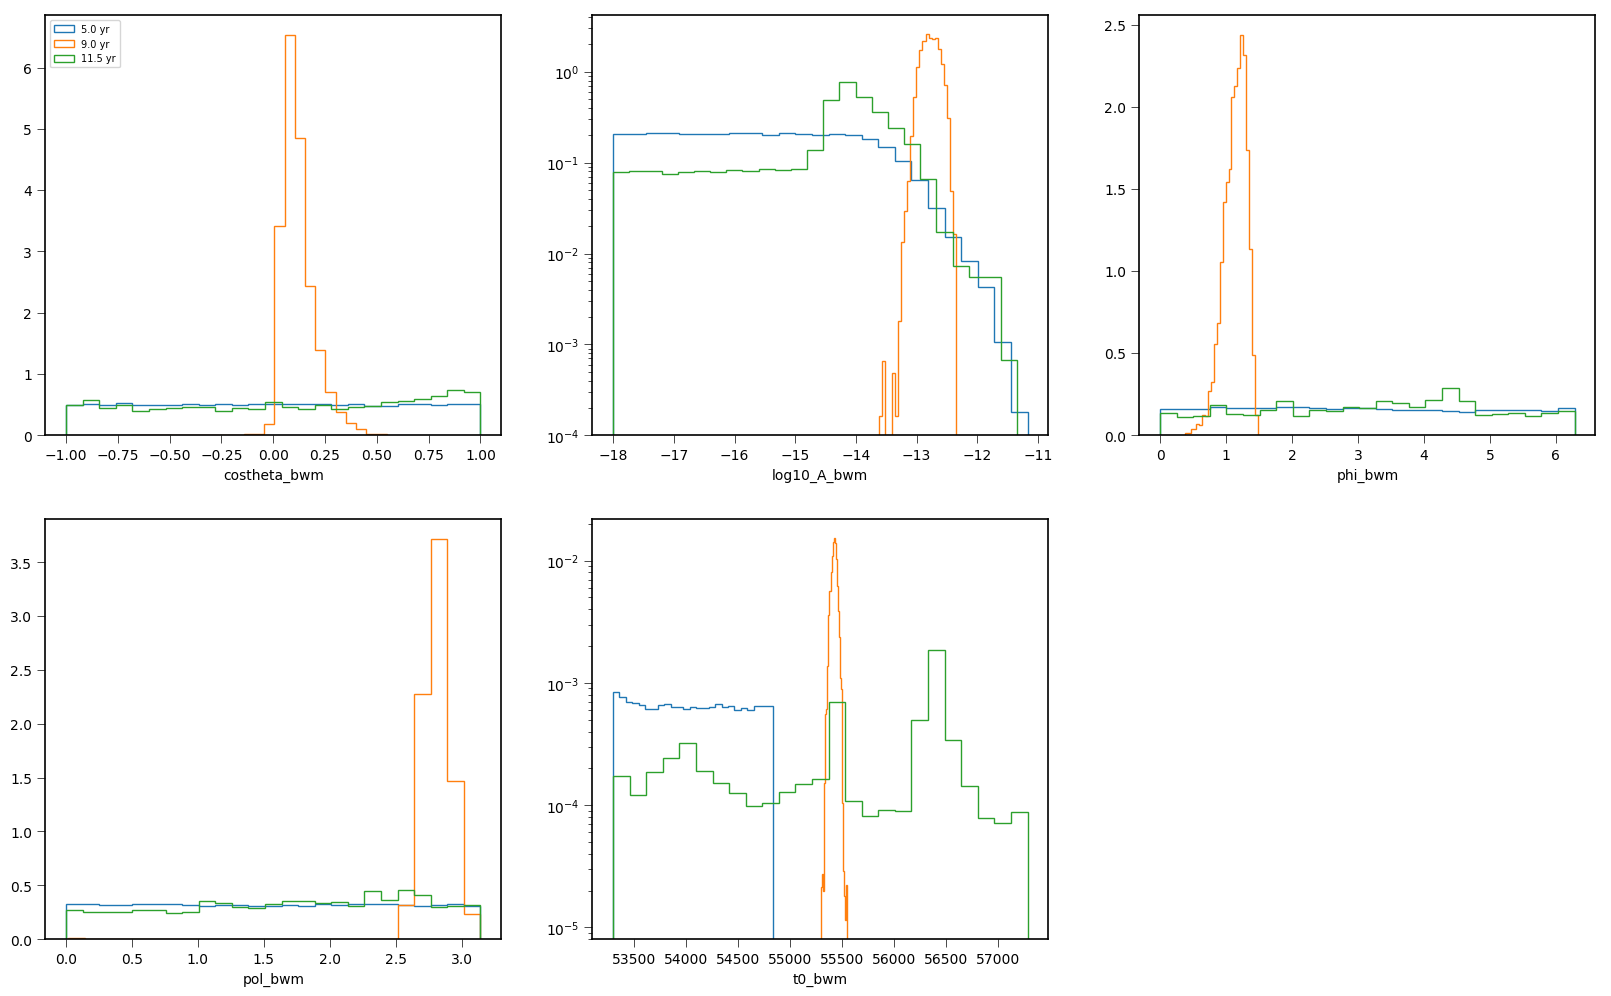

In [33]:
ephem = 'DE421'
#ephem = 'bayesephem'

# setup plotting axes
ax = []
fig = plt.figure(figsize=(20,12))
for pp, par in enumerate(bwm_pars):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].set_xlabel(par)

# loop over slices
slices = [5, 9, 11.5]
for slice_yr in slices:
    
    rundir = '/home/pbaker/nanograv/bwm/slices/{:.1f}/{}/'.format(slice_yr, ephem)
    
    # get parameters
    with open(rundir + 'params.txt', 'r') as f:
        params = [line.rstrip('\n') for line in f]

    # find BWM parameters
    bwm_pars = []
    for p in params:
        if 'bwm' in p:
            bwm_pars.append(p)

    bwm_idx = [params.index(p) for p in bwm_pars]
    idx_A = bwm_pars.index('log10_A_bwm')
    idx_t0 = bwm_pars.index('t0_bwm')
    
    chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                            sep='\t', dtype=float, header=None).values
    burn = int(0.25 * len(chain_raw))
    chain = chain_raw[burn:]
    chain_bwm = chain[:,bwm_idx]  # no ephem model

    corr = acor(chain_bwm[:,idx_A])[0]
    N = len(chain_bwm)
    print("{:.1f} yr -- {:s}".format(slice_yr, ephem))
    print("N = {}, corr = {:.1f}, Neff = {:.1f}".format(N, corr, N/corr))
    
    for pp, par in enumerate(bwm_pars):
        ax[pp].hist(chain_bwm[:,pp], bins=25, normed=True, histtype='step',
                    label="{:.1f} yr".format(slice_yr))

ax[0].legend(loc='upper left')
#for a in ax:
#    a.set_yscale('log')
ax[idx_A].set_yscale('log')
ax[idx_t0].set_yscale('log')

fig.savefig('/home/pbaker/anomaly_timeslice.pdf')

In [ ]:
ephem = 'DE421'

# setup plotting axes
ax = []
fig = plt.figure(figsize=(20,12))
for pp, par in enumerate(params):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].set_xlabel(par)

# loop over slices
slices = [9,9.5,10,10.5,11.0]
for slice_yr in slices:
    
    rundir = '/home/pbaker/nanograv/bwm/slices/{:.1f}/{}/'.format(slice_yr, ephem)
    
    chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                            sep='\t', dtype=float, header=None).values
    burn = int(0.25 * len(chain_raw))
    chain = chain_raw[burn:]    
    chain_bwm = chain[:,-9:-4]  # no ephem model

    corr = acor(chain_bwm[:,idx_A])[0]
    N = len(chain_bwm)
    print("{:.1f} yr -- {:s}".format(slice_yr, ephem))
    print("N = {}, corr = {:.1f}, Neff = {:.1f}".format(N, corr, N/corr))
    
    for pp, par in enumerate(params):
        ax[pp].hist(chain_bwm[:,pp], bins=25, normed=True, histtype='step',
                    label="{:.1f} yr".format(slice_yr))

ax[0].legend(loc='upper left')
for a in ax:
    a.set_yscale('log')
#ax[idx_A].set_yscale('log')
#ax[idx_t0].set_yscale('log')

# read in several slices

In [47]:
ephem = 'DE421'

# loop over slices
ch = {}
slices = [5,7.5,9,11.5] #np.arange(5,12,0.5)
for slice_yr in slices:
    
    rundir = '/home/pbaker/nanograv/bwm/slices/{:.1f}/{}/'.format(slice_yr, ephem)
    
    # get parameters
    with open(rundir + 'params.txt', 'r') as f:
        params = [line.rstrip('\n') for line in f]

    # find BWM parameters
    bwm_pars = []
    for p in params:
        if 'bwm' in p:
            bwm_pars.append(p)

    bwm_idx = [params.index(p) for p in bwm_pars]
    idx_A = bwm_pars.index('log10_A_bwm')
    idx_t0 = bwm_pars.index('t0_bwm')
    
    chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                            sep='\t', dtype=float, header=None).values
    burn = int(0.25 * len(chain_raw))
    chain = chain_raw[burn:]    
    chain_bwm = chain[:,bwm_idx]
    
    # wrap pol chain (anomaly pol=3)
    chain_bwm[chain_bwm[:,3]>np.pi/2, 3] -= np.pi
    
    ch[slice_yr] = chain_bwm

    corr = acor(chain_bwm[:,idx_A])[0]
    N = len(chain_bwm)
    print("{:.1f} yr -- {:s}".format(slice_yr, ephem))
    print("N = {}, corr = {:.1f}, Neff = {:.1f}".format(N, corr, N/corr))

5.0 yr -- DE421
N = 369939, corr = 3.3, Neff = 111383.4
7.5 yr -- DE421
N = 213000, corr = 240.3, Neff = 886.4
9.0 yr -- DE421
N = 120825, corr = 318.6, Neff = 379.3
11.5 yr -- DE421
N = 84075, corr = 173.7, Neff = 484.1


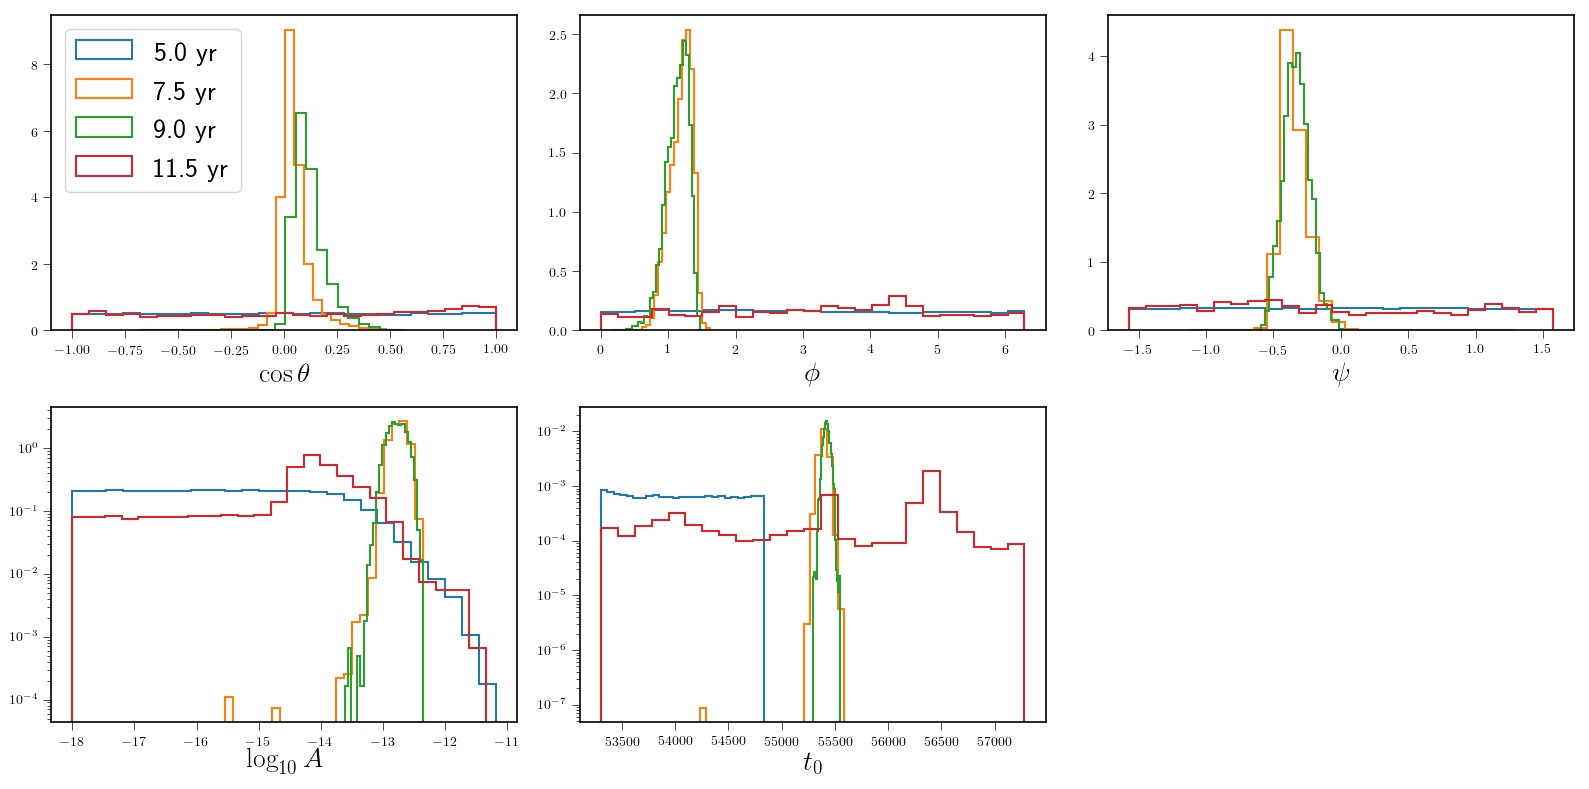

In [66]:
plot_pars = [r'$\cos\theta$', r'$\phi$', r'$\psi$', r'$\log_{10} A$', r'$t_0$']
plot_idx = [0, 2, 3, 1, 4]

# setup plotting axes
ax = []
fig = plt.figure(figsize=(16,8))
for pp, par in enumerate(plot_pars):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].set_xlabel(par, fontsize=20)
    for slice_yr in slices:
        ax[pp].hist(ch[slice_yr][:,plot_idx[pp]], lw=1.5,
                    bins=25, normed=True, histtype='step',
                    label="{:.1f} yr".format(slice_yr))

ax[0].legend(loc='upper left', fontsize=20)

ax[3].set_yscale('log')
ax[4].set_yscale('log')

plt.tight_layout()

fig.savefig('/home/pbaker/anomaly_timeslice.pdf')

In [ ]:
# setup plotting axes
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'BWM $t_0$ (MJD)')

slices = [5, 9.0, 11.5]#[5,7.5,9,11.5]
for slice_yr in slices:
    ax.hist(ch[slice_yr][:,idx_t0], bins=30, normed=True, histtype='step',
                    label="{:.1f} yr".format(slice_yr))
ax.legend(loc='upper left')
ax.set_yscale('log')

In [ ]:
slice_yr = 9.0

ephem = 'DE421'
rundir = '/home/pbaker/nanograv/bwm/slices/{:.1f}/{:s}/'.format(slice_yr, ephem)
chain_raw = np.loadtxt(rundir + 'chain_1.txt')
burn = int(0.25 * len(chain_raw))
chain = chain_raw[burn:]
chain_bwm = chain[:,-9:-4]  # no ephem model
N = len(chain_bwm)
print("{:.1f} yr -- {:s}".format(slice_yr, ephem))
print("N = {}".format(N)

plt.hist(chain_bwm[:,idx_t0], bins=25, normed=True, histtype='step', label=ephem)

ephem = 'bayesephem'
rundir = '/home/pbaker/nanograv/bwm/slices/{:.1f}/{:s}/'.format(slice_yr, ephem)
chain_raw = np.loadtxt(rundir + 'chain_1.txt')
burn = int(0.25 * len(chain_raw))
chain = chain_raw[burn:]
chain_bwm = chain[:,-20:-15]  # w/ ephem model
N = len(chain_bwm)
print("{:.1f} yr -- {:s}".format(slice_yr, ephem))
print("N = {}".format(N))

plt.hist(chain_bwm[:,idx_t0], bins=25, normed=True, histtype='step', label=ephem)

plt.legend(loc='upper left')
plt.yscale('log')